# Ethereum on-chain data
francesco.balsamo.20@ucl.ac.uk

Previous literature (Bovet, 2019) (Ante, 2021) has shown the existence of a causal relationships between cryptocurrency price movements and changes of its transaction network topology revealing the interplay between structural quantities, indicative of the collective behaviour of network users, and price movements. This project is an effort to extract meaningful information from cryptocurrency on-chain data to predict market dynamics using complex networks metrics and machine learning techniques.

## 1. Exploratory data analysis

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set seaborn plotting theme
# sns.set_theme()
sns.set_style("darkgrid")

### Daily number of transactions and value in Ether

In [3]:
%%bigquery eth_nr_trnsctn --project charged-sector-315517

SELECT DATE(block_timestamp) date, count(distinct `hash`) nr_trnsctn, sum(value) / 1e18 value
FROM `ethereum_onchain.transactions`
where value > 0 
group by date
order by date

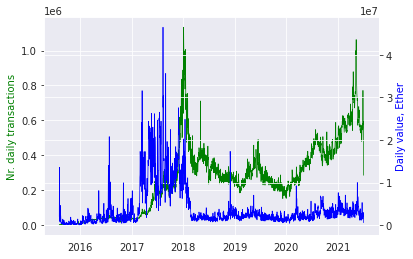

In [4]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(eth_nr_trnsctn["date"], eth_nr_trnsctn["nr_trnsctn"], 'g-', label = "", linewidth = .7)
ax2.plot(eth_nr_trnsctn["date"], eth_nr_trnsctn["value"], 'b-', label = "", linewidth = .7)
ax1.set_ylabel('Nr. daily transactions', color='g')
ax2.set_ylabel('Daily value, Ether', color='b')
# plt.legend()
plt.show()

### Daily number of nodes

In [5]:
%%bigquery eth_nr_address --project charged-sector-315517

SELECT DATE(block_timestamp) date, count(distinct from_address) nr_from_address, count(distinct to_address) nr_to_address
FROM `ethereum_onchain.transactions`
where value > 0 
group by date
order by date

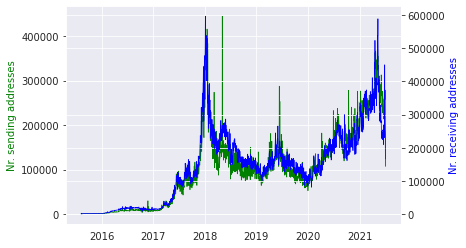

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(eth_nr_address["date"], eth_nr_address["nr_from_address"], 'g-', label = "", linewidth = .7)
ax2.plot(eth_nr_address["date"], eth_nr_address["nr_to_address"], 'b-', label = "", linewidth = .7)

# ax1.set_xlabel('X data')
ax1.set_ylabel('Nr. sending addresses', color='g')
ax2.set_ylabel('Nr. receiving addresses', color='b')
# plt.legend()
plt.show()

### Gini coefficient

In [7]:
%%bigquery eth_gini --project charged-sector-315517

with 
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `ethereum_onchain.traces`
    where to_address is not null
    and status = 1
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `ethereum_onchain.traces`
    where from_address is not null
    and status = 1
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `ethereum_onchain.transactions` as transactions
    join `ethereum_onchain.blocks` as blocks on blocks.number = transactions.block_number
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `ethereum_onchain.transactions`
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2015-07-30', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

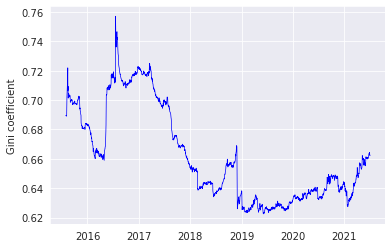

In [8]:
plt.plot(eth_gini['date'], eth_gini['gini'], 'b-', label = "", linewidth = .7)
plt.ylabel('Gini coefficient')
# plt.legend()
plt.show()

### Daily fees

In [9]:
%%bigquery eth_fee --project charged-sector-315517

SELECT DATE(block_timestamp) date
--, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) fee
--, min(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) min_fee
, avg(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) mean_fee
--, max(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18) max_fee
FROM `ethereum_onchain.transactions`
group by date
order by date

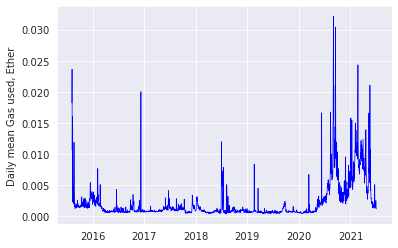

In [10]:
plt.plot(eth_fee['date'], eth_fee['mean_fee'], 'b-', label = "mean fee", linewidth = .7)
plt.ylabel('Daily mean Gas used, Ether')
# plt.legend()
plt.show()

## 2. Network analysis [RUN ONLY FOR 01-01-2020]

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#pyspark --packages graphframes:graphframes:0.8.1-spark2.4-s_2.12
conf = pyspark.SparkConf().setAll([('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'),
                                   ('spark.jars.packages', 'graphframes:graphframes:0.8.1-spark2.4-s_2.12')])

spark = SparkSession.builder \
    .master('yarn') \
    .appName('spark-bigquery-crypto') \
    .config(conf = conf) \
    .getOrCreate()

spark

In [3]:
bucket = "dataproc-staging-us-central1-397709471406-lrrymuq9"
spark.conf.set('temporaryGcsBucket', bucket)

In [4]:
from graphframes import *

In [18]:
# Load data from BigQuery.
table = 'charged-sector-315517:ethereum_onchain.transactions'

# .option("filter", "DATE(block_timestamp) between '2020-01-01' and '2020-01-31'") \
eth_transactions = spark.read.format('bigquery') \
                          .option('table', table) \
                          .option("filter", "DATE(block_timestamp) = '2020-01-01'") \
                          .load()

eth_transactions.createOrReplaceTempView('eth_transactions')

In [19]:
edges = spark.sql('''
                    SELECT from_address as src, to_address as dst, value, block_timestamp, `hash` hash_trnsct
                    FROM eth_transactions
                    where from_address is not null and to_address is not null
                    --and DATE(block_timestamp) = '2020-01-01'
                    ''')

In [20]:
nodes = edges \
         .select("src") \
         .union(edges.select("dst")) \
         .distinct() \
         .withColumnRenamed('src', 'id')

In [21]:
nodes.show(2)

+--------------------+
|                  id|
+--------------------+
|0x0d86a7a059f316f...|
|0x7238223d1baa660...|
+--------------------+
only showing top 2 rows



In [22]:
edges.show(2)

+--------------------+--------------------+-----+-------------------+--------------------+
|                 src|                 dst|value|    block_timestamp|         hash_trnsct|
+--------------------+--------------------+-----+-------------------+--------------------+
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-01 02:08:52|0x5f10a5daa31cb78...|
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-01 06:21:38|0x90e16e94bb357cf...|
+--------------------+--------------------+-----+-------------------+--------------------+
only showing top 2 rows



In [23]:
g = GraphFrame(nodes, edges)

### Degrees distributions

In [35]:
%%time
gDegrees = g.inDegrees.join(g.outDegrees, 'id', 'outer').na.fill(0)
gDegrees.sort(F.desc("inDegree")).show(5, False)
gDegrees.sort(F.desc("outDegree")).show(5, False)

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0xdac17f958d2ee523a2206206994597c13d831ec7|48981   |0        |
|0x68e54af74b22acaccffa04ccaad13be16ed14eac|8517    |0        |
|0xcadb96858fe496bb6309622f9023ba2defb5d540|8340    |0        |
|0x8fdcc30eda7e94f1c12ce0280df6cd531e8365c5|6859    |0        |
|0x06012c8cf97bead5deae237070f9587f8e7a266d|5291    |0        |
+------------------------------------------+--------+---------+
only showing top 5 rows

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0xea674fdde714fd979de3edf0f56aa9716b898ec8|0       |12060    |
|0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5|0       |4814     |
|0x84295d5e054d8cff5a22428b195f5a1615bd644f|0       |4357     |
|0x8babf0ba311a

In [36]:
%%time
gDegrees.drop("id").describe().show()

+-------+------------------+------------------+
|summary|          inDegree|         outDegree|
+-------+------------------+------------------+
|  count|            159279|            159279|
|   mean|2.9224756559245098|2.9224756559245098|
| stddev|136.58425654668912|52.896254157525966|
|    min|                 0|                 0|
|    max|             48981|             12060|
+-------+------------------+------------------+

CPU times: user 3.43 ms, sys: 713 µs, total: 4.14 ms
Wall time: 4.59 s


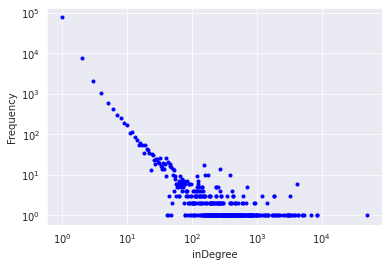

CPU times: user 1.14 s, sys: 23.9 ms, total: 1.17 s
Wall time: 6.66 s


In [40]:
%%time
log_count_list = [x['count'] for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('count').collect()]
log_inDegree_list = [x['inDegree'] for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('inDegree').collect()]

fig, ax = plt.subplots()
plt.plot(log_inDegree_list, log_count_list, 'b.')
plt.ylabel('Frequency')
plt.xlabel('inDegree')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

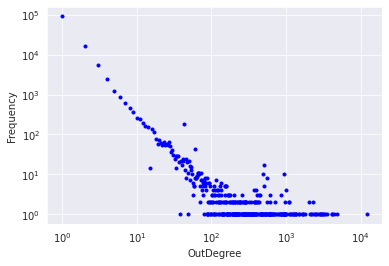

CPU times: user 926 ms, sys: 0 ns, total: 926 ms
Wall time: 6.28 s


In [41]:
%%time
log_count_list = [x['count'] for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('count').collect()]
log_outDegree_list = [x['outDegree'] for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('outDegree').collect()]


fig, ax = plt.subplots()
plt.plot(log_outDegree_list, log_count_list, 'b.')
plt.ylabel('Frequency')
plt.xlabel('OutDegree')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

### PageRank

In [34]:
%%time
# Run PageRank algorithm and show top 10 results.
results = g.pageRank(resetProbability=0.1, maxIter=10)
results.vertices.select("id", "pagerank").sort(F.desc("pagerank")).show(10, False)

+------------------------------------------+------------------+
|id                                        |pagerank          |
+------------------------------------------+------------------+
|0xdac17f958d2ee523a2206206994597c13d831ec7|8871.21936128007  |
|0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be|1470.7253331038562|
|0x5e07b6f1b98a11f7e04e7ffa8707b63f1c177753|1463.9912669229016|
|0x68e54af74b22acaccffa04ccaad13be16ed14eac|1437.0096557882616|
|0xcfcf469b76113c5e7218f8275eaf10a881ac106d|1181.9322675161513|
|0xcadb96858fe496bb6309622f9023ba2defb5d540|759.1644792166619 |
|0xd7cc16500d0b0ac3d0ba156a584865a43b0b0050|714.6486228622971 |
|0xbcf935d206ca32929e1b887a07ed240f0d8ccd22|684.3307191834742 |
|0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48|559.1603035104554 |
|0x2b591e99afe9f32eaa6214f7b7629768c40eeb39|516.1284156281846 |
+------------------------------------------+------------------+
only showing top 10 rows

CPU times: user 51.5 ms, sys: 9.45 ms, total: 61 ms
Wall time: 4min 41s


### Motifs

In [32]:
%%time
# Count pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show(5)

+--------------------+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|                  e2|
+--------------------+--------------------+--------------------+--------------------+
|[0xd7a8ddd1ff0fe8...|[0xd7a8ddd1ff0fe8...|[0x76f0fb9c5cfe95...|[0x76f0fb9c5cfe95...|
|[0xcae9cd51a1e816...|[0xcae9cd51a1e816...|[0xc2c21fcdea61ad...|[0xc2c21fcdea61ad...|
|[0xcae9cd51a1e816...|[0xcae9cd51a1e816...|[0xc2c21fcdea61ad...|[0xc2c21fcdea61ad...|
|[0x54c666e8e09ab4...|[0x54c666e8e09ab4...|[0xc2fb36db76571a...|[0xc2fb36db76571a...|
|[0x54c666e8e09ab4...|[0x54c666e8e09ab4...|[0xc2fb36db76571a...|[0xc2fb36db76571a...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

CPU times: user 2.01 ms, sys: 3.9 ms, total: 5.91 ms
Wall time: 18.8 s


In [ ]:
%%time
triangles = g.triangleCount()
triangles.select("id", "count").sort(F.desc("count")).show(5, False)

+------------------------------------------+-----+
|id                                        |count|
+------------------------------------------+-----+
|0xdac17f958d2ee523a2206206994597c13d831ec7|3255 |
|0x1091c132630310aca62f62cb155f2506070c2ec5|1070 |
|0xd78e0d77f0801c22561deaa5e958667fc590973f|1070 |
|0x29d5b3c621606fc8b1a76395f3cc091dd7fb5152|701  |
|0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be|471  |
+------------------------------------------+-----+
only showing top 5 rows

CPU times: user 28.8 ms, sys: 33.6 ms, total: 62.4 ms
Wall time: 4min 49s


### Connected components
https://en.wikipedia.org/wiki/Component_(graph_theory)

In [24]:
sc = spark.sparkContext
sc.setCheckpointDir('graphframes_cps')

In [28]:
%%time
conncomp = g.connectedComponents()
conncomp.select("id", "component").sort(F.desc("component")).show(5, False)

+------------------------------------------+-------------+
|id                                        |component    |
+------------------------------------------+-------------+
|0xa1380417ea4721b69c36a747da16ccf96ef984b9|1709396984323|
|0x05947d13b2b7a86a0b8fa83e8641050b87d73b2b|1709396983830|
|0xc86f6dbbf283b79c89d18bbd69f89f21deddce3e|1683627180652|
|0xc3fa2be82e7e7124fa6f75c22bec0119683a0265|1683627180652|
|0x50e9bd47939b996439d00b40a66a05378c6e0c41|1675037245656|
+------------------------------------------+-------------+
only showing top 5 rows

CPU times: user 16 ms, sys: 4.89 ms, total: 20.9 ms
Wall time: 1min 14s


### Strongly connected components

https://en.wikipedia.org/wiki/Strongly_connected_component

In [ ]:
%%time
strconncomp = g.stronglyConnectedComponents(maxIter=10)
strconncomp.select("id", "component").sort(F.desc("component")).show(5, False)

### Label Propagation Algorithm (LPA)
https://en.wikipedia.org/wiki/Label_propagation_algorithm

In [ ]:
%%time
labprop = g.labelPropagation(maxIter=5)
labprop.select("id", "label").show(5, False)